# Tutorial on single-cell trajectory alignment using Genes2Genes

Genes2Genes (G2G) aims to guide downstream comparative analysis of single-cell reference and query systems along any axis of progression (e.g. differentiation pseudotime, disease/treatment response pseudotime etc.). This notebook describes how we can use G2G framework to infer and analyse gene-level trajectory alignments between a given reference and query dataset.

In this tutorial, we are going to compare trajectories between two treatment groups (PAM and LPS) of mouse bone marrow-derived dendritic cells from Shalek et al (2014). The single cell datasets and their pseudotime estimates were downloaded from https://github.com/shenorrLab/cellAlign (Alpert et al 2018) and packaged into adata objects. There are 2 gene modules: global (core antiviral module) and local (peaked inflammatory module) considered by Alpert et al (2018), and we use the local module as an example comparison.

In [7]:
#Environment setup
#conda create --name g2g_env python=3.8 
#conda activate g2g_env
#pip install genes2genes

In [8]:
import anndata
import numpy as np
import seaborn as sb
import numpy as np
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

from genes2genes import Main
from genes2genes import ClusterUtils
from genes2genes import TimeSeriesPreprocessor
from genes2genes import PathwayAnalyser
from genes2genes import VisualUtils

### Load anndata reference and query objects

Make sure that each adata object has: <br>
(1) log normalized gene expression in `adata.X` <br>
(2) pseudotime estimates in `adata.obs['time']`


In [9]:
input_dir = "../notebooks/data/"
adata_ref = anndata.read_h5ad(input_dir + "adata_pam_local.h5ad")  # Reference dataset
adata_query = anndata.read_h5ad(input_dir + "adata_lps_local.h5ad")  # Query dataset

## 1. Preparing data for alignment


### Pseudotime range check

Check whether the current range of pseudotime values are between 0 and 1. If not, run min max normalization.


In [10]:
print(min(adata_ref.obs["time"]), max(adata_ref.obs["time"]))
print(min(adata_query.obs["time"]), max(adata_query.obs["time"]))

## uncomment below if the pseudotime range is not [0,1] for any of the objects
# adata_ref.obs['time'] = TimeSeriesPreprocessor.Utils.minmax_normalise(np.asarray(adata_ref.obs['time']))
# adata_query.obs['time'] = TimeSeriesPreprocessor.Utils.minmax_normalise(np.asarray(adata_query.obs['time']))

0.0 1.0
0.0 1.0


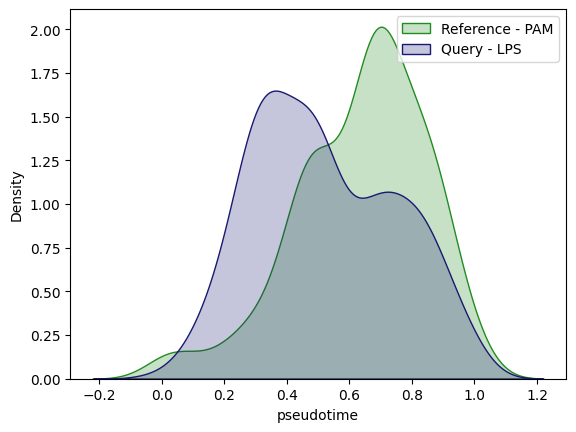

In [11]:
# Visualize the pseudotime distributions
sb.kdeplot(
    adata_ref.obs["time"], fill=True, label="Reference - PAM", color="forestgreen"
)
sb.kdeplot(
    adata_query.obs["time"], fill=True, label="Query - LPS", color="midnightblue"
)
plt.xlabel("pseudotime")
plt.legend()
plt.show()

### Determine the number of discrete pseudotime points to align

We can use optbinning package (https://gnpalencia.org/optbinning/installation.html) to get a heuristic estimate about the number of discrete time points to consider by running below on each dataset.<br> **Note:** Run `pip install optbinning` if this is not already installed.


In [12]:
from optbinning import ContinuousOptimalBinning

x = np.asarray(adata_ref.obs.time)
optb = ContinuousOptimalBinning(name="pseudotime", dtype="numerical")
optb.fit(x, x)
print(len(optb.splits))

x = np.asarray(adata_query.obs.time)
optb = ContinuousOptimalBinning(name="pseudotime", dtype="numerical")
optb.fit(x, x)
print(len(optb.splits))

(CVXPY) Mar 02 06:38:51 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Mar 02 06:38:51 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
14
14


Accordingly, we go with `n_bins=14`


In [13]:
n_bins = 14

### Define which cell type annotations and color scheme to use for visualization purposes

`annotation_colname` and `joint_cmap`


In [14]:
# define annotation column name in the adata obs
annotation_colname = "annotation"
adata_ref.obs[annotation_colname] = [x.split("_")[1] for x in adata_ref.obs_names]
adata_query.obs[annotation_colname] = [x.split("_")[1] for x in adata_query.obs_names]

# define the joint colormap to use for both reference and query
col = np.array(sb.color_palette("colorblind"))[range(4)]
joint_cmap = {"1h": col[0], "2h": col[1], "4h": col[2], "6h": col[3]}

Inspect the cell type compositions around each discrete pseudotime point (x-axis) to see if it reasonably represents the entire trajectory of interest.


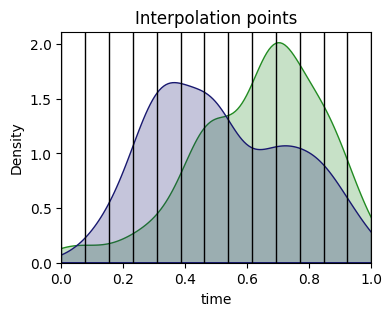

In [15]:
VisualUtils.plot_pseudotime_dists_with_interpolation_points(
    adata_ref, adata_query, n_bins
)

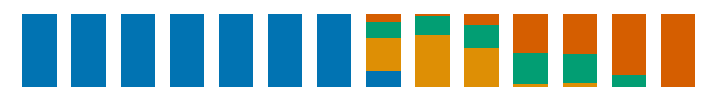

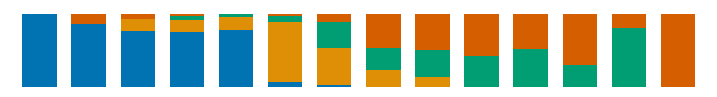

In [16]:
n_bins = 14
VisualUtils.plot_celltype_barplot(adata_ref, n_bins, annotation_colname, joint_cmap)
VisualUtils.plot_celltype_barplot(adata_query, n_bins, annotation_colname, joint_cmap)

## 2. G2G trajectory alignment

**Example gene sets to align:** all human transcription factors, all highly variable genes, lineage-specific genes of interest, a specific pathway gene set etc.


In [17]:
# define the gene list to align
gene_list = adata_ref.var_names
print(len(gene_list), "genes")

89 genes


### Aligning all genes


In [18]:
aligner = Main.RefQueryAligner(adata_ref, adata_query, gene_list, n_bins)  #
aligner.align_all_pairs()

Genes2Genes (v0.2.0)
Dynamic programming alignment of gene pseudotime trajectories using a bayesian information-theoretic framework
Interpolator initialization completed
Aligner initialised to align trajectories of 179 reference cells & 290 query cells in terms of 89 genes
Running gene-level alignment: 🧬


100%|██████████| 89/89 [00:10<00:00,  8.77it/s]

Alignment completed! ✅


To access gene-level alignments, use the dictionary: `aligner.results_map` which carries all gene alignment objects. <br>
e.g. `aligner.results_map['TNF']`


DDDIDIDIDDDMMMMMIIIIIID
DDDIDIDIDDDMMMMMIIIIIID

01234567890123456789012 Alignment index 
012 3 4 56789012      3 Reference index
***-*-*-********------*
---*-*-*---***********-
   0 1 2   34567890123  Query index
DDDIDIDIDDDMMMMMIIIIIID 5-state string 


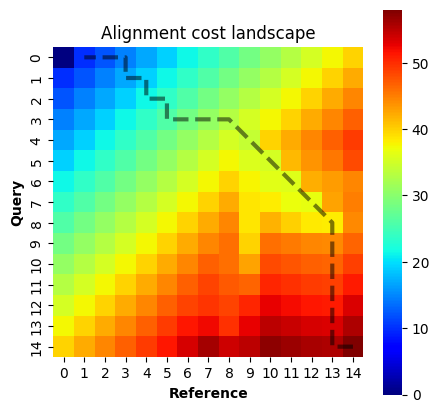

In [19]:
gene_obj = aligner.results_map["TNF"]
alignment_str = gene_obj.alignment_str
print(alignment_str)
print(VisualUtils.color_al_str(alignment_str))
print()
print(gene_obj.al_visual)
# Alignment landscape of costs (Note: dashed black path is the optimal alignment)
gene_obj.landscape_obj.plot_alignment_landscape()
# Note: optimal path diagonals represent matches;
# vertical and horizontal paths could represent either warp matches or indels (mismatches)

Visualise alignment in terms of both the cell-type compositions, as well as actual and interpolated gene expression. <br>
Top left: Visualise alignmebt in terms of cell-type composition <br>
Bottom left: the mean trends and interpolated distributions of gene expression along pseudotime. <br>
Bottom right: the actual gene expression values along pseudotime.


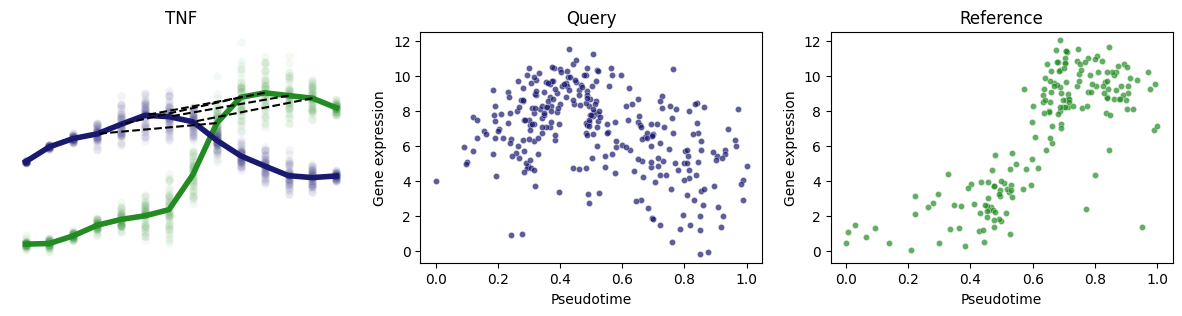

In [20]:
VisualUtils.plotTimeSeries("TNF", aligner, plot_cells=True)

DDDIDIDIDDDMMMMMIIIIIID
Optimal alignment cost: 57.99 nits
Alignment similarity percentage: 21.74 %


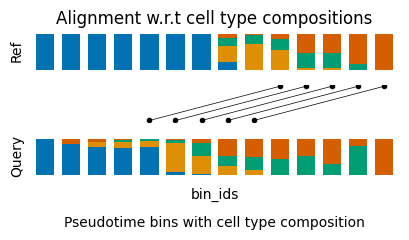

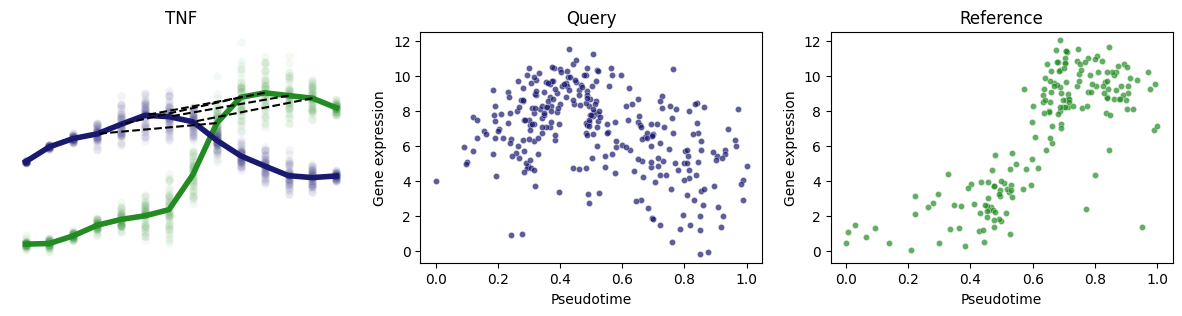

In [21]:
VisualUtils.show_gene_alignment(
    "TNF", aligner, adata_ref, adata_query, annotation_colname, joint_cmap
)

# Visualise gene-level alignment in terms of only the cell-type composition
# VisualUtils.visualize_gene_alignment(aligner.results_map['TNF'], adata_ref, adata_query, annotation_colname, cmap=joint_cmap)

### Aggregate (average) cell-level alignment across all aligned genes

This is an average alignment which is sampled based on the frequency distribution of alignment states between each pair of reference and query timepoints. The heatmap value gives the number of genes where the corresponding timepoints have been matched. Note: There can still be different patterns of alignment across these genes (100% mismatching, 100% matching, early mismatching, late mismatching gene groups) which we will find by clustering in the next section.


Average Alignment:  IDDDMMMMMMMMMIIIDID (cell-level)
% similarity: 47.37


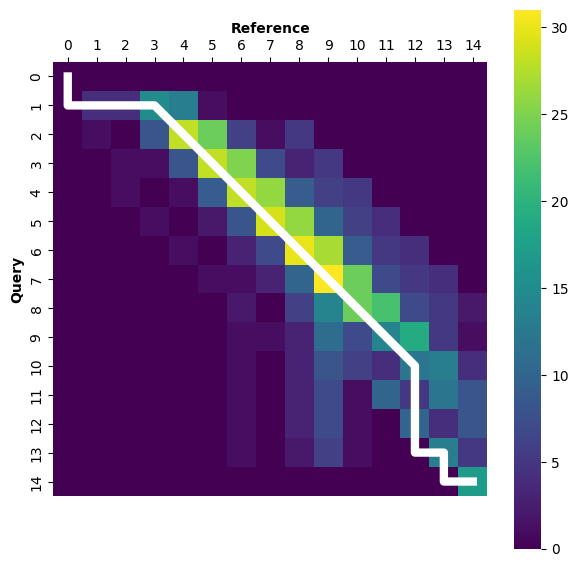

In [22]:
aligner.get_aggregate_alignment()
# Note: White path represents the average alignment path where diagonals represent matches;
# vertical and horizontal paths could represent either warp matches or indels (mismatches)

## 3. Analysing gene-level alignments

Ranking genes based on their alignment similarities


Mean alignment similarity percentage (matched %): 
50.39 %


,Gene,alignment_similarity_percentage,opt_alignment_cost,l2fc,color,abs_l2fc
63,CCRL2,0.2174,55.943686,-0.487688,red,0.487688
77,NFKBIA,0.2174,54.673471,-0.091748,red,0.091748
68,NLRP3,0.2174,57.177548,0.069058,red,0.069058
3,TNF,0.2174,57.990078,-0.006439,red,0.006439
45,C5AR1,0.2727,57.858236,0.8711,red,0.8711
...,...,...,...,...,...,...
34,NUP54,0.75,30.744062,0.012993,green,0.012993
15,CD44,0.7647,28.366715,-0.021366,green,0.021366
19,PLAGL2,0.8235,31.807955,-0.051268,green,0.051268
51,ZSWIM4,0.8235,30.214576,0.030379,green,0.030379


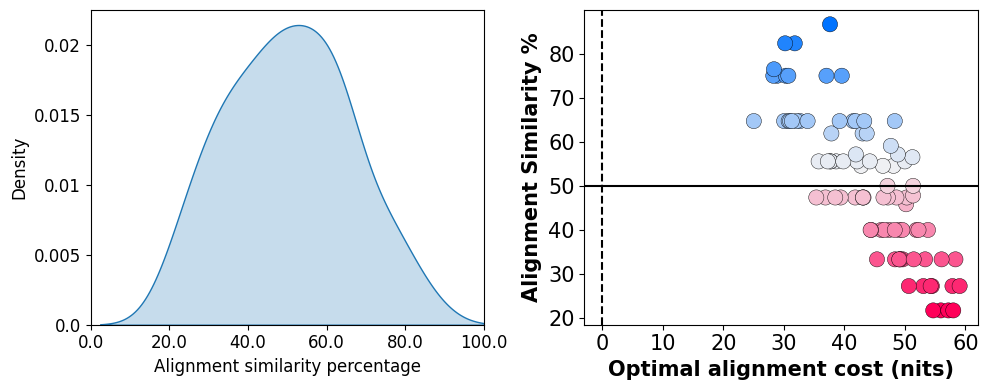

In [23]:
df = aligner.get_stat_df()  # ordered genes according to alignment similarity statistics
df

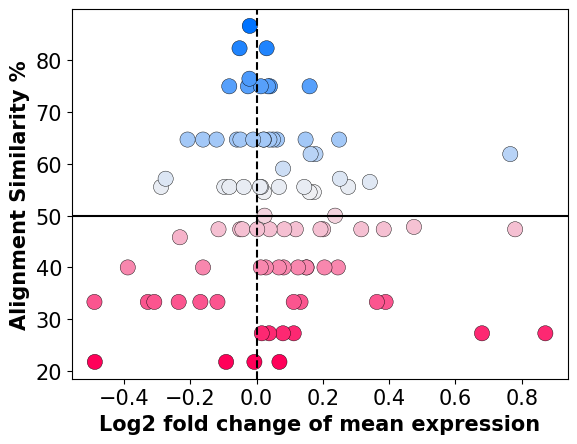

In [24]:
VisualUtils.plot_alignmentSim_vs_l2fc(df)

A ranked list of genes based on their first match occurrence


In [25]:
earliest_match_sorted_genes_list = aligner.show_ordered_alignments()

In the order of the first match occurrence along pseudotime
Gene      Alignment
--------  ------------------------
PTAFR     MDDMMMMMMMMMMIIDI
OSBPL3    MDMMMMMMVVVVVVDIDDDDD
RFFL      MDDDMMMMMMMMMMIII
TNFAIP2   MDDMMMMMMMIDIDIIIIDD
SGMS2     DMMMMMMMMMMMMIM
SLC16A10  DMMMMMMMMMMMIIIDD
FPR1      DMMMMMMMMMIIDIIIDDD
FAM20C    DMMMMMMMMDDDMMIIII
CLEC4D    IMMDIDMMMMMMMIIIDDD
TSHZ1     DDMMMMMMMVVVVVVIDDDDD
IL1F9     DDMMMMMMMVVVVVVIDDDDD
PSTPIP2   DDMMMMMMMVVVVVIDIDDDD
RELA      DDMMMMMMMMMMMMII
NUP54     DDMMMMMMMMMMMMII
DDHD1     DDMMMMMMMMMMMMII
NRP2      DDMMMMMMMMMMMIIID
TREM1     DDMMMMMMMMMIDIIIIDD
GRAMD1B   DDMMMMMMMMMIIMMM
TOP1      DDMMMMMMMMIDIIIIIDDD
ICOSL     DDMMMMMMMMIIMMMM
DUSP16    DDMMMMMMMMIIMMMM
PTPRE     DDMMMMMMMMIIIIIIDDDD
LDLR      DDMMMMMMMMIIDIIIIDDD
TNIP1     DDMMMMMMMMIIIIIIDDDD
PLAGL2    DDDMMMMMMMMMMMVVV
ZSWIM4    DDDMMMMMMMMMMMVVV
ZC3H12C   DDDMMMMMMVVVVVVVIDDDDD
AK150559  DDDMMMMMVVVVVVVVIDDDDDD
F10       IDDMMMMVVVVVVVVIDDDDDDDD
FAM108C   DDDMMMMMMMMMMMI

## Gene-set overrepresentation analysis on the top dissimilar genes

Checking top dissimilar genes, i.e, only <=30% similarity along pseudotime


In [26]:
threshold_similarity = 0.3
topDEgenes = df[list(df["alignment_similarity_percentage"] <= threshold_similarity)][
    "Gene"
]
# Calling wrapper function for GSEAPy enrichr inferface
pathway_df = PathwayAnalyser.run_overrepresentation_analysis(topDEgenes)
pathway_df.head(5)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,-log10 Adjusted P-value,-log10 FDR q-val
13,KEGG_2021_Human,C-type lectin receptor signaling pathway,4/104,1.414253e-07,0.000007,0,0,132.600000,2091.300110,NFKBIA;NLRP3;TNF;MALT1,5.182020,5.182020
14,KEGG_2021_Human,NF-kappa B signaling pathway,4/104,1.414253e-07,0.000007,0,0,132.600000,2091.300110,NFKBIA;TNF;CXCL2;MALT1,5.182020,5.182020
0,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,4/200,1.944057e-06,0.000013,0,0,67.326531,885.393278,NFKBIA;CCRL2;TNF;CXCL2,4.898378,4.898378
1,MSigDB_Hallmark_2020,Inflammatory Response,4/200,1.944057e-06,0.000013,0,0,67.326531,885.393278,NFKBIA;C5AR1;CCRL2;NLRP3,4.898378,4.898378
15,KEGG_2021_Human,NOD-like receptor signaling pathway,4/181,1.305897e-06,0.000040,0,0,74.625235,1011.068962,NFKBIA;NLRP3;TNF;CXCL2,4.392729,4.392729


## Clustering alignments

Running experiment to determine the distance threshold for alignment clusters from hierarchical clustering. We aim to select a locally optimal threshold that gives a good trade-off between high mean Silhouette score and low number of clusters which can be biologically meaningful.


Compute distance matrix
- using levenshtein distance metric
Experimental mode: exploring different thresholds


 68%|██████▊   | 67/99 [00:00<00:00, 361.11it/s]

-- Cluster diagnostic plots


Potential candidates for distance threshold: a locally optimal thresholds that gives a good trade-off between high mean Silhouette score and low number of clusters 


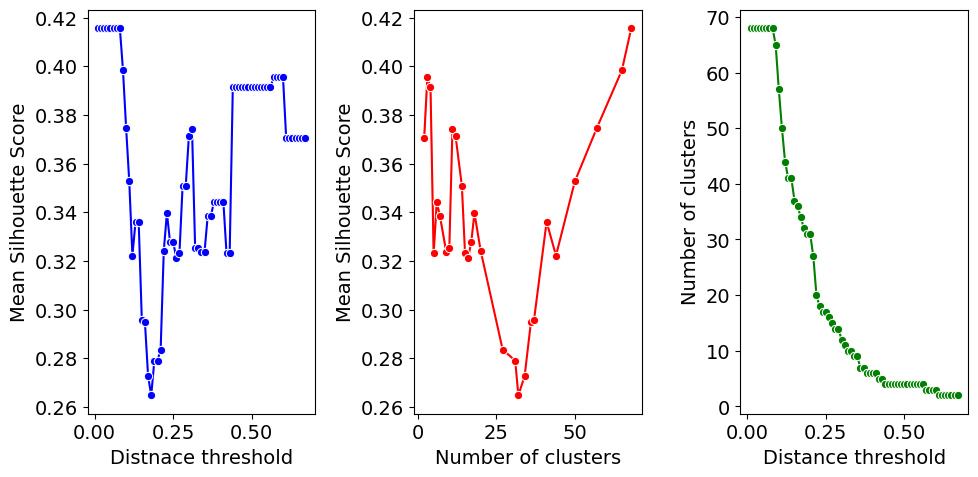

In [27]:
df = ClusterUtils.run_clustering(aligner, metric="levenshtein", experiment_mode=True)

Run clustering with the chosen distance threshold. In this case we select 0.37


In [28]:
ClusterUtils.run_clustering(aligner, metric="levenshtein", DIST_THRESHOLD=0.37)

Compute distance matrix
- using levenshtein distance metric
run agglomerative clustering | distance threshold = 0.37
silhouette_score:  0.33852896526013104


Visualise gene alignment grouped together in each cluster <br>
Note: diagonals represent matches; vertical and horizontal paths could represent either warp matches or indels (mismatches)


Cluster ID | Number of genes in the cluster


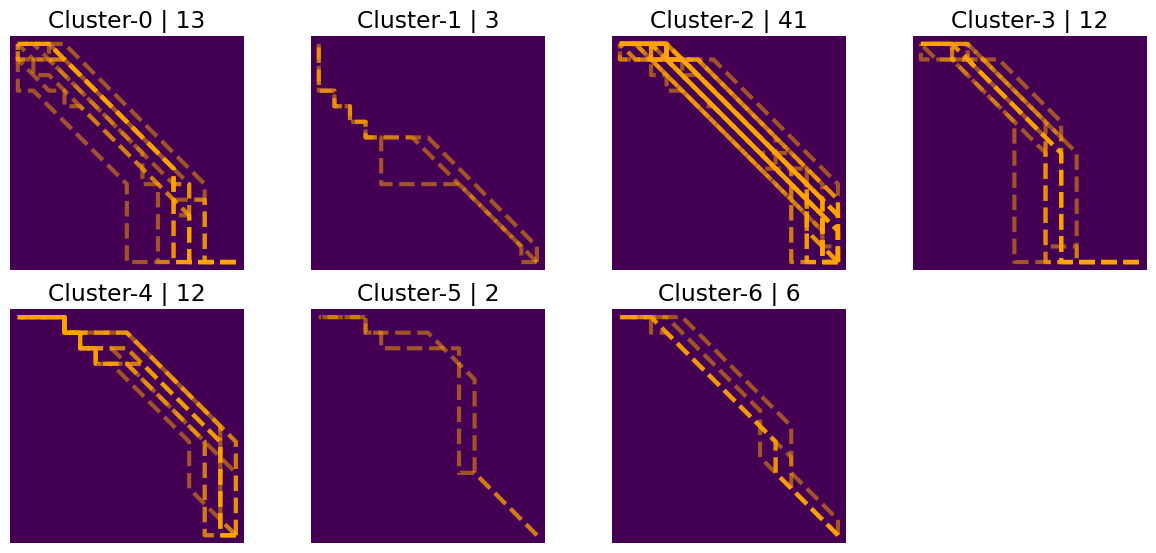

In [29]:
ClusterUtils.visualise_clusters(aligner, n_cols=4, figsize=(10, 6))

Visualise the distance matrix used in the clustering


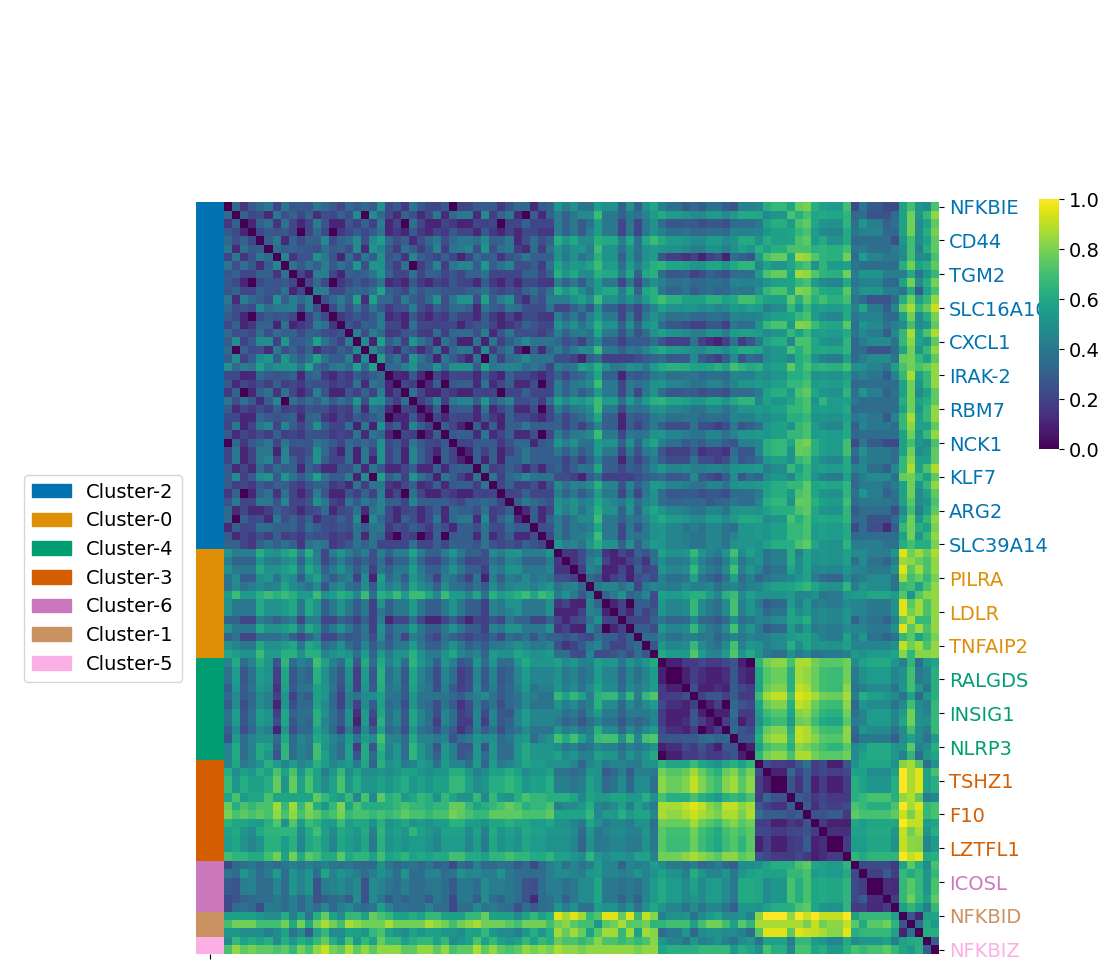

In [30]:
VisualUtils.plot_distmap_with_clusters(aligner)

Print the aggregate (average) cell-level alignments for each cluster


In [31]:
ClusterUtils.print_cluster_average_alignments(aligner)

cluster:  0 IDDDMMMMMMMIIIDIIIDDD ( 13 genes)
cluster:  1 IIIDIDIDIDIDDDMMMMMMM ( 3 genes)
cluster:  2 IDDDMMMMMMMMMMIIID ( 41 genes)
cluster:  3 IDDDMMMMMIMVVVVVIDDDDD ( 12 genes)
cluster:  4 IIIDDDDDDDMMMMMMIIIIID ( 12 genes)
cluster:  5 IIIDIDIDDDDDDMMMMVMVVM ( 2 genes)
cluster:  6 DDMMMMMMMMIIMMMM ( 6 genes)


In [32]:
# To access the genes in a particular cluster
cluster_id = 0
print(aligner.gene_clusters[cluster_id])

# To print all gene alignments in the cluster
aligner.show_cluster_alignment_strings(cluster_id)

['FPR1', 'TREM1', 'TOP1', 'PILRA', 'CLEC4D', 'C5AR1', 'PTPRE', 'LDLR', 'LCP2', 'TNIP1', 'CPD', 'TNFAIP2', 'SPATA13']
DMMMMMMMMMIIDIIIDDD
DDMMMMMMMMMIDIIIIDD
DDMMMMMMMMIDIIIIIDDD
DDIDMMMMMMMIIIIIIDDDD
IMMDIDMMMMMMMIIIDDD
IIIDMMMMMMIIIIIDDDDDDD
DDMMMMMMMMIIIIIIDDDD
DDMMMMMMMMIIDIIIIDDD
DDDMMMMMMMMMIIIIIDD
DDMMMMMMMMIIIIIIDDDD
IDIDMMMMMMMMMIIIDDD
MDDMMMMMMMIDIDIIIIDD
IDDMMMMMMIIDIIIIIDDDDD


In [33]:
# To get the cluster id of an alignment object, e.g. TNF,
aligner.results_map["TNF"].cluster_id

4

### Average alignment of any given subset of genes

e.g. `gene_list[40:60]` or a specific gene set in a specific pathway, e.g. EMT


Average Alignment:  IDDDMMMMMMMIIDIIIIDDD (cell-level)


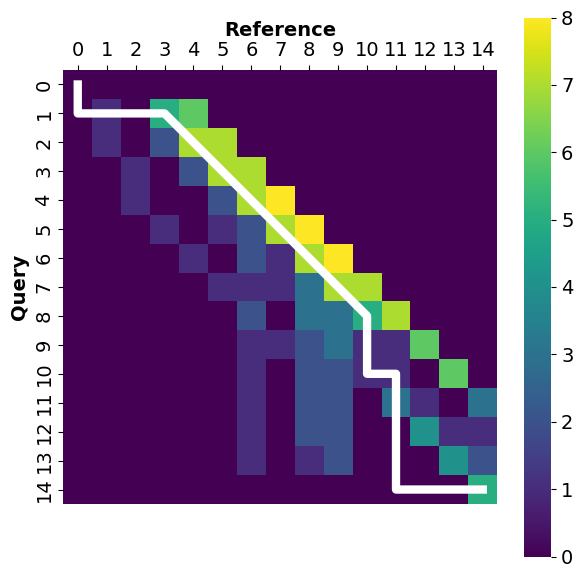

In [34]:
GENE_SUBSET = gene_list[40:60]
aligner.get_aggregate_alignment_for_subset(GENE_SUBSET)

### Exploring alignment and trends of a given gene set


Following calls a wrapper to extract a specified pathway gene set from msigdb database via blitzgsea package (https://github.com/MaayanLab/blitzgsea)


In [35]:
IGS = PathwayAnalyser.InterestingGeneSets(gene_list)
# IGS.get_available_pathway_list('KEGG_2021_Human')
# IGS.get_available_pathway_list('MSigDB_Hallmark_2020')

Initialising to use KEGG_2021_Human and MSigDB_Hallmark_2020 only


You could also add a new library by calling below. <br>


In [36]:
# ===== Check available libraries in enrichr

# import blitzgsea
# blitzgsea.enrichr.print_libraries()

# ===== Add a selected library

# library_name = "GO_Molecular_Function_2021"
# IGS.add_library(blitzgsea.enrichr.get_library(library_name), library_name)

#### Check the aggregate alignment and interpolated gene expression trends for a given pathway gene set as below.


In [37]:
IGS.add_new_set_from_msigdb(
    "MSigDB_Hallmark_2020", "Epithelial Mesenchymal Transition", user_setname="EMT"
)

Gene set: =======  EMT
mean matched percentage:  51.04 %
Average Alignment:  IDDDMMMMMMMMMMIMI (cell-level)
- Plotting average alignment path
- Plotting z-normalised interpolated mean trends


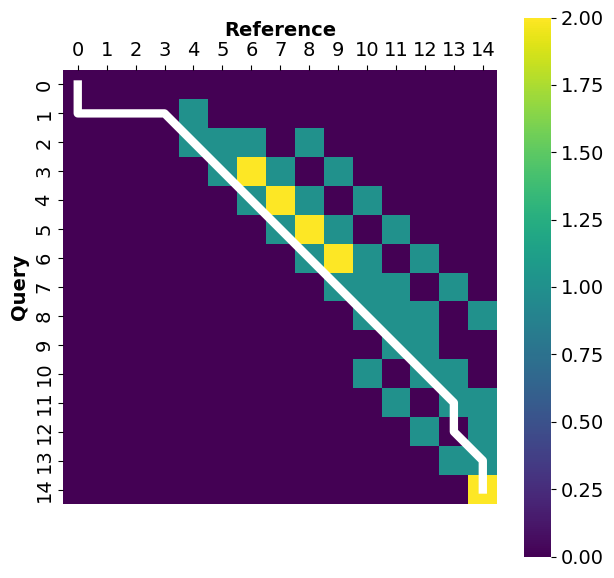

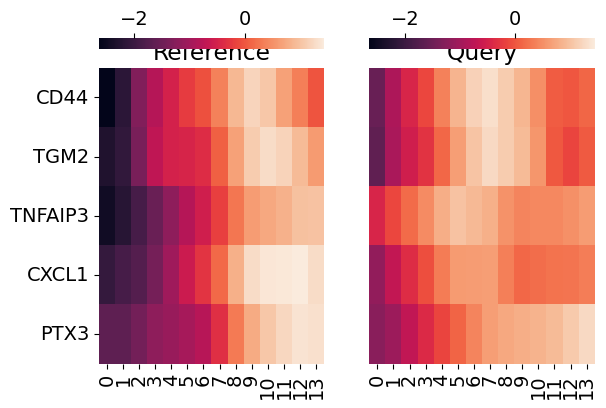

In [38]:
PathwayAnalyser.get_pathway_alignment_stat(
    aligner, IGS.SETS["EMT"], "EMT", cluster=True, FIGSIZE=(3, 6)
)

Gene set: =======  EMT
mean matched percentage:  51.29 %
Average Alignment:  IIDDDDMMMMMMMMMIVID (cell-level)
- Plotting average alignment path
- Plotting z-normalised interpolated mean trends


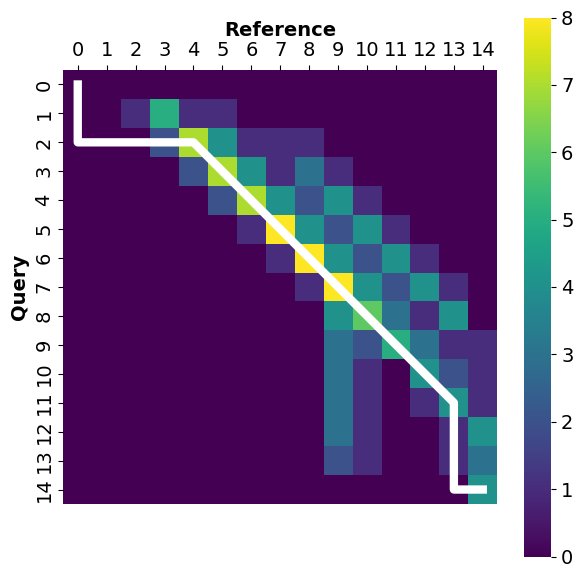

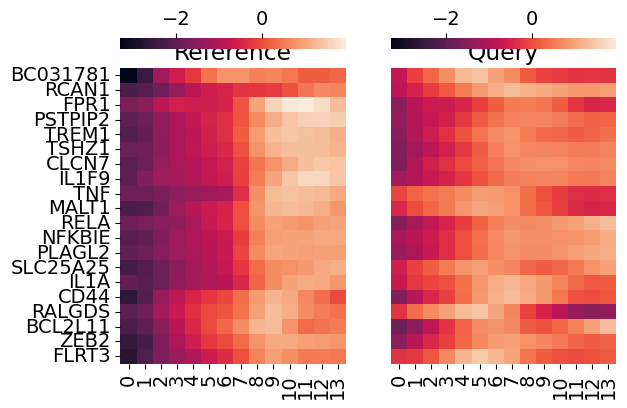

In [39]:
PathwayAnalyser.get_pathway_alignment_stat(
    aligner, gene_list[0:20], "EMT", cluster=True, FIGSIZE=(3, 6)
)